In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import f1_score
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input,GlobalAveragePooling2D,BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('D:/Lung/archive/chest_xray'):
    for filename in filenames:
        os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

(617, 1300, 3)


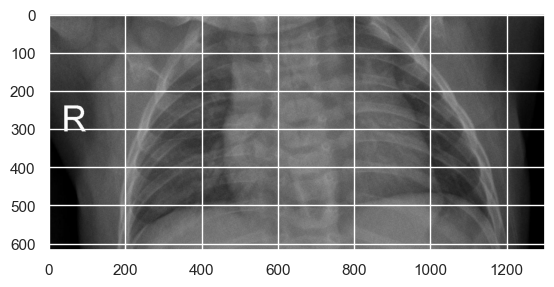

In [2]:
from glob import glob
test_normal=glob("D:/Lung/archive/chest_xray/test/NORMAL/*.jpeg")
test_ph=glob("D:/Lung/archive/chest_xray/test/PNEUMONIA/*.jpeg")

train_normal=glob("D:/Lung/archive/chest_xray/train/NORMAL/*.jpeg")
train_ph=glob("D:/Lung/archive/chest_xray/train/PNEUMONIA/*.jpeg")

val_normal=glob("D:/Lung/archive/chest_xray/val/NORMAL/*.jpeg")
val_ph=glob("D:/Lung/archive/chest_xray/val/PNEUMONIA/*.jpeg")

test10=cv2.imread(test_normal[16])
print(test10.shape)
plt.imshow(test10)

(592, 992, 3)


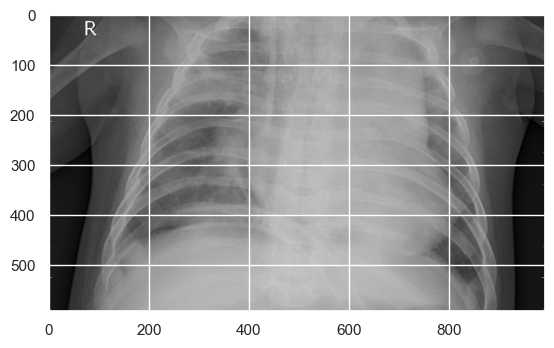

In [3]:
test16=cv2.imread(test_ph[16])
print(test16.shape)
plt.imshow(test16)

In [4]:
g=np.ones((len(val_ph),1))
g1=np.zeros((len(val_normal),1))
print("% of PNEUMONIA in val:",(len(g)/(len(g1)+len(g)))*100)

g=np.ones((len(train_ph),1))
g1=np.zeros((len(train_normal),1))
print("% of PNEUMONIA in train:",(len(g)/(len(g1)+len(g)))*100)

g=np.ones((len(test_ph),1))
g1=np.zeros((len(test_normal),1))
print("% of PNEUMONIA in val:",(len(g)/(len(g1)+len(g)))*100)


% of PNEUMONIA in val: 50.0
% of PNEUMONIA in train: 74.29064417177914
% of PNEUMONIA in val: 62.5


In [5]:
#224x224 for MobileNet, 229x229 for Inception and VGG
img_width_224, img_height_224 = 224, 224
img_width_229, img_height_229 = 229, 229
batchsize = 32


train_224 = keras.utils.image_dataset_from_directory(
    directory='D:/Lung/archive/chest_xray/train/',
    labels='inferred',
    label_mode='binary',
    batch_size=batchsize,
    image_size=(img_width_224, img_height_224))

validation_224 = keras.utils.image_dataset_from_directory(
    directory='D:/Lung/archive/chest_xray/val/',
    labels='inferred',
    label_mode='binary',
    batch_size=batchsize,
    image_size=(img_width_224, img_height_224))

test_224 = keras.utils.image_dataset_from_directory(
    directory='D:/Lung/archive/chest_xray/test/',
    labels='inferred',
    label_mode='binary',
    batch_size=batchsize,
    image_size=(img_width_224, img_height_224))


train_229 = keras.utils.image_dataset_from_directory(
    directory='D:/Lung/archive/chest_xray/train/',
    labels='inferred',
    label_mode='binary',
    batch_size=batchsize,
    image_size=(img_width_229, img_height_229))

validation_229 = keras.utils.image_dataset_from_directory(
    directory='D:/Lung/archive/chest_xray/val/',
    labels='inferred',
    label_mode='binary',
    batch_size=batchsize,
    image_size=(img_width_229, img_height_229))

test_229 = keras.utils.image_dataset_from_directory(
    directory='D:/Lung/archive/chest_xray/test/',
    labels='inferred',
    label_mode='binary',
    batch_size=batchsize,
    image_size=(img_width_229, img_height_229))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


**Augmentation for robust model**

As you can see in this data, some images have different rotation, brightness, etc. I can use them as alreade augmented data, coze it close to real data (doctor can makes different pictures with different rotation), but model with raw data won't robust enough - data batches will have same patterns (same or very similar rotation and brightness). 

For robust model I'll use ImageDataGenerator from Tensorflow. It makes augmented data all batches differently, so model will take similar, but not the same data.

In [6]:
from PIL import Image

img=Image.open(test_normal[16])
img.show()

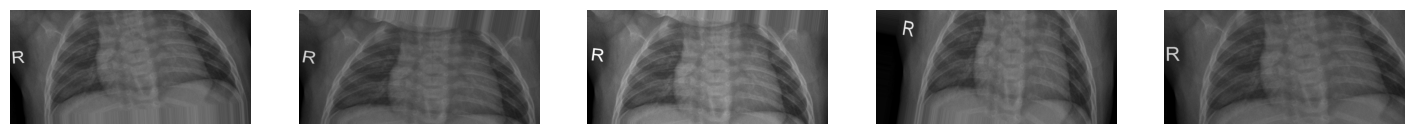

In [7]:

images=np.expand_dims(test10,axis=0)
def plot(data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = plt.subplots(nrows=1, ncols=5, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    plt.show()



data_generator = ImageDataGenerator(#horizontal_flip=True,
                                   #vertical_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=2,
                                  rotation_range=10,
                                  brightness_range=(0.8,1.2),
                                  #channel_shift_range=70.0,
                                  #fill_mode='nearest',
                                  zoom_range=[0.8,1.1])
plot(data_generator)

In [8]:
def make_set(train,test,validation):
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    for feature, label in train:
        x_train.append(feature.numpy())
        y_train.append(label.numpy())

    for feature, label in test:
        x_test.append(feature.numpy())
        y_test.append(label.numpy())
    
    for feature, label in validation:
        x_val.append(feature.numpy())
        y_val.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
    x_train = np.concatenate(x_train, axis=0)
    x_val = np.concatenate(x_val, axis=0)
    x_test = np.concatenate(x_test, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    return x_train,x_val,x_test,y_train,y_val,y_test

In [9]:
x_train224,x_val224,x_test224,y_train224,y_val224,y_test224=make_set(train_224,test_224,validation_224)
x_train229,x_val229,x_test229,y_train229,y_val229,y_test229=make_set(train_229,test_229,validation_229)

In [10]:
print("Shape of 'x_train':", x_train224.shape)
print("Shape of 'y_train':", y_train224.shape)
print("Shape of 'x_val':", x_val224.shape)
print("Shape of 'y_val':", y_val224.shape)
print("Shape of 'x_test':", x_test224.shape)
print("Shape of 'y_test':", y_test224.shape)

Shape of 'x_train': (5216, 224, 224, 3)
Shape of 'y_train': (5216, 1)
Shape of 'x_val': (16, 224, 224, 3)
Shape of 'y_val': (16, 1)
Shape of 'x_test': (624, 224, 224, 3)
Shape of 'y_test': (624, 1)


In [11]:
def histogram(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  xc = range(len(train_acc))

  a=plt.figure(1,figsize=(7,5))

  plt.plot(xc,train_loss)
  plt.plot(xc,val_loss)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('train_loss vs val_loss')
  plt.grid(True)
  plt.legend(['train','val'])

  plt.style.use(['classic'])

  b=plt.figure(2,figsize=(7,5))
  plt.plot(xc,train_acc)
  plt.plot(xc,val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('accuracy')
  plt.title('train_acc vs val_acc')
  plt.grid(True)
  plt.legend(['train','val'],loc=4)
  plt.style.use(['classic'])
  return a,b

# What accuracy I want to achieve?

It is very important question for most ML tasks. I define 2 metrics - 2 accuracy "point". First - Bayes error - theoretical minimum error (maximum accuracy) and human - level error (acccuracy), which can't be lower that Bayes error. Model's error can be lower that human - level, but it can not be lower that Bayes error.

According to this [article](https://www.wikidoc.org/index.php/Pneumonia_chest_x_ray), in some case it's hard to identify pneumonia due to different stage of it or [symptoms may be the same as a cold or flu](https://www.nhlbi.nih.gov/health/pneumonia/diagnosis). I couldn't find exact percent of successful identification of pneumonia, so I assume that human - level error is 5% (95% accuracy), Bayes error is 2%(98% accuracy). 

# InceptionV3

In [12]:
Inception=tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top = False, input_shape=(img_width_229, img_height_229, 3))
VGG16=tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top = False, input_shape=(img_width_229, img_width_229, 3))


In [34]:
Inception.layers[-2]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               26214912  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 1)                

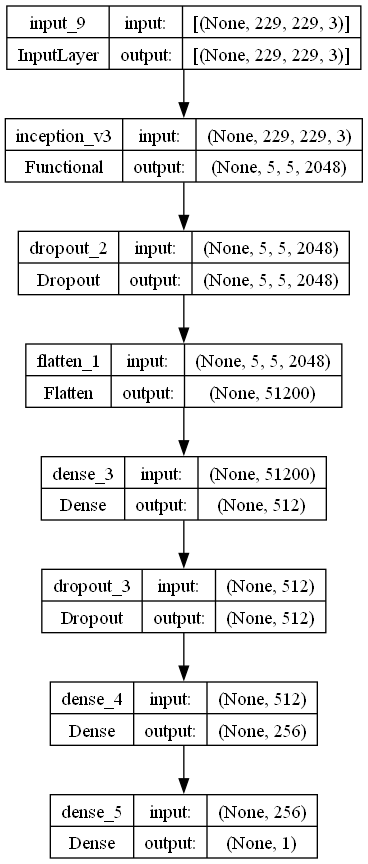

In [35]:
#I found that BatchNormalization worked worse as top layers, than DropOut
def Inception_model():
    base_model = Inception
    for layer in base_model.layers:
        layer.trainable = False


    model = Sequential()
    model.add(Input(shape=(img_width_229, img_height_229,3)))
    model.add(base_model)
    
    model.add(Dropout(0.3))
    model.add(Flatten())
    #model.add(Dense(512, activation='leaky_relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


model_Inception = Inception_model()
model_Inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model_Inception.summary()  
keras.utils.plot_model(model_Inception, show_shapes=True)

In [36]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [37]:
#uisng test set as validation data, coze it prevent huge overfitting
hist_Inception = model_Inception.fit(x_train229, y_train229, epochs= 20, validation_data= (x_test229, y_test229),callbacks=[early_stopping])



Epoch 1/20
163/163 [==============================] - 132s 758ms/step - loss: 25.3577 - accuracy: 0.8635 - precision: 0.9100 - recall: 0.9058 - val_loss: 8.3090 - val_accuracy: 0.8478 - val_precision: 0.9251 - val_recall: 0.8231
Epoch 2/20
163/163 [==============================] - 119s 733ms/step - loss: 3.7402 - accuracy: 0.8947 - precision: 0.9286 - recall: 0.9298 - val_loss: 2.1333 - val_accuracy: 0.7019 - val_precision: 0.6796 - val_recall: 0.9897
Epoch 3/20
163/163 [==============================] - 119s 732ms/step - loss: 0.3080 - accuracy: 0.8995 - precision: 0.9607 - recall: 0.9017 - val_loss: 0.9513 - val_accuracy: 0.8574 - val_precision: 0.8558 - val_recall: 0.9282
Epoch 4/20
163/163 [==============================] - 118s 723ms/step - loss: 0.2279 - accuracy: 0.9319 - precision: 0.9806 - recall: 0.9267 - val_loss: 0.6676 - val_accuracy: 0.8686 - val_precision: 0.8598 - val_recall: 0.9436
Epoch 5/20
163/163 [==============================] - 119s 728ms/step - loss: 0.2440 - 

1/1 [==============================] - 2s 2s/step


<Axes: >

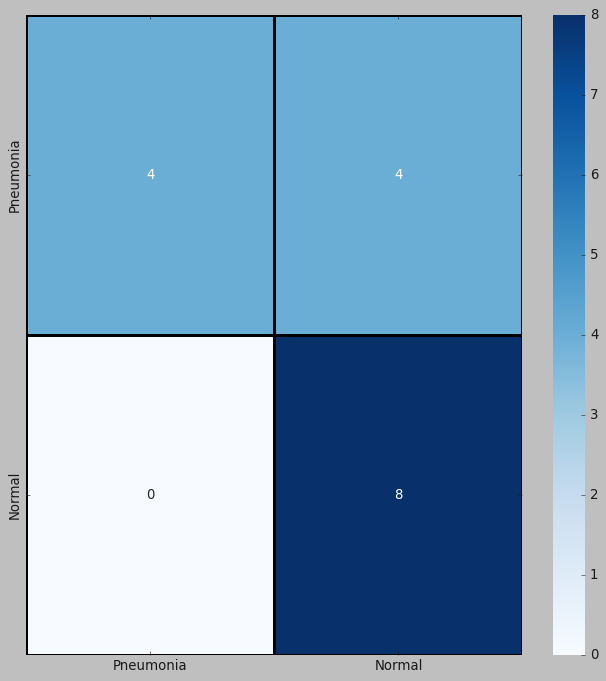

In [38]:
predict_Inception=model_Inception.predict(x_val229)
classes_Inception=(predict_Inception>0.5).astype(int)
#labels=["NORMAL","PNEUMONIA"]
cm_Inception  = confusion_matrix(y_val229, classes_Inception)
cm = pd.DataFrame(cm_Inception , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [39]:
roc_inc=roc_auc_score(y_val229,classes_Inception)

In [40]:
f1_inc=f1_score(y_val229,classes_Inception,average="binary")

In [41]:
print(classification_report(y_val229, classes_Inception, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.50      0.67         8
   Normal (Class 1)       0.67      1.00      0.80         8

           accuracy                           0.75        16
          macro avg       0.83      0.75      0.73        16
       weighted avg       0.83      0.75      0.73        16



(<Figure size 560x400 with 1 Axes>, <Figure size 560x400 with 1 Axes>)


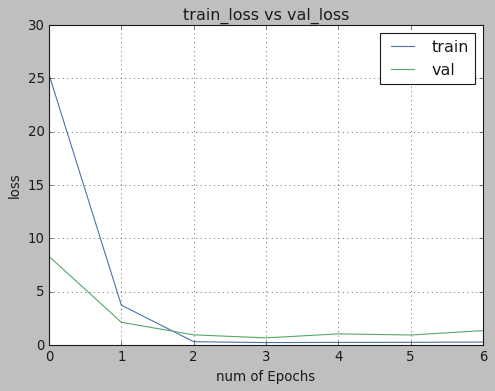

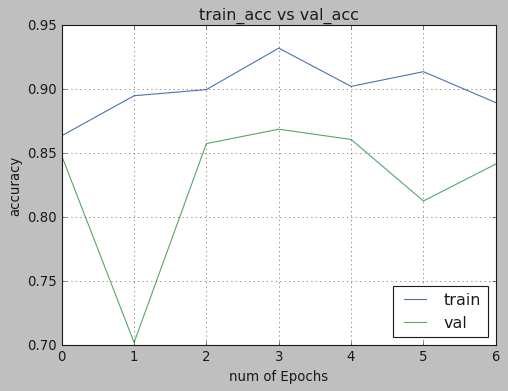

In [42]:
print(histogram(hist_Inception))

In [43]:
model_Inception.save('model_Inception.h5')

D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Inception with augmentation**

In [44]:
hist_augm_Inception = model_Inception.fit(data_generator.flow(x_train229,y_train229,batch_size=64, 
                                       seed=27,
                                       shuffle=False), 
    epochs= 20, validation_data= (x_test229, y_test229),callbacks=[early_stopping])


Epoch 1/20
82/82 [==============================] - 150s 2s/step - loss: 0.4019 - accuracy: 0.8443 - precision: 0.9369 - recall: 0.8475 - val_loss: 0.4339 - val_accuracy: 0.8317 - val_precision: 0.9179 - val_recall: 0.8026
Epoch 2/20
82/82 [==============================] - 148s 2s/step - loss: 0.3430 - accuracy: 0.8531 - precision: 0.9617 - recall: 0.8356 - val_loss: 0.3917 - val_accuracy: 0.8494 - val_precision: 0.8834 - val_recall: 0.8744
Epoch 3/20
82/82 [==============================] - 145s 2s/step - loss: 0.3142 - accuracy: 0.8673 - precision: 0.9639 - recall: 0.8534 - val_loss: 0.3991 - val_accuracy: 0.8285 - val_precision: 0.9275 - val_recall: 0.7872
Epoch 4/20
82/82 [==============================] - 149s 2s/step - loss: 0.3383 - accuracy: 0.8485 - precision: 0.9617 - recall: 0.8292 - val_loss: 0.5390 - val_accuracy: 0.8429 - val_precision: 0.8687 - val_recall: 0.8821
Epoch 5/20
82/82 [==============================] - 149s 2s/step - loss: 0.3448 - accuracy: 0.8554 - precisi

1/1 [==============================] - 0s 333ms/step


<Axes: >

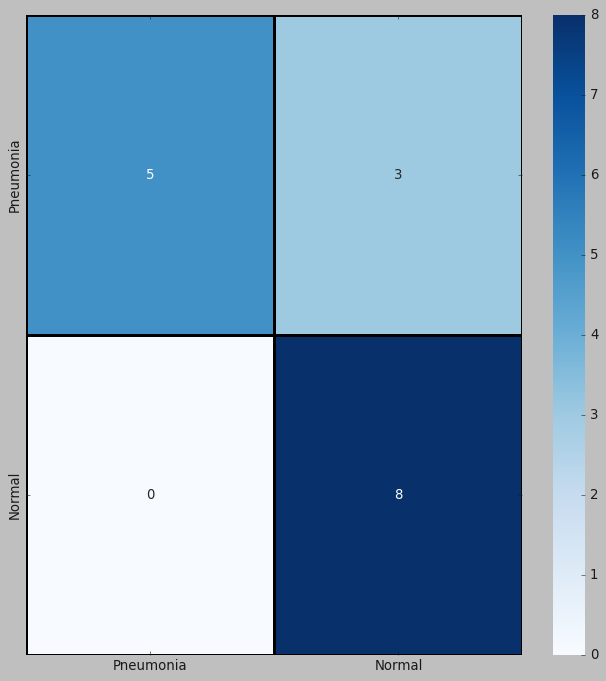

In [45]:
predict_aug_Inception=model_Inception.predict(x_val229)
classesInception_augm=(predict_aug_Inception>0.5).astype(int)
labels=["Pneumonia","Normal"]
cm_augm_Inception  = confusion_matrix(y_val229, classesInception_augm)
cm = pd.DataFrame(cm_augm_Inception , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [46]:

roc_inc_aug=roc_auc_score(y_val229,classesInception_augm)

In [47]:
f1_inc_augm=f1_score(y_val229,classesInception_augm,average="binary")

In [48]:
print(classification_report(y_val229, classesInception_augm, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.62      0.77         8
   Normal (Class 1)       0.73      1.00      0.84         8

           accuracy                           0.81        16
          macro avg       0.86      0.81      0.81        16
       weighted avg       0.86      0.81      0.81        16



(<Figure size 560x400 with 1 Axes>, <Figure size 560x400 with 1 Axes>)


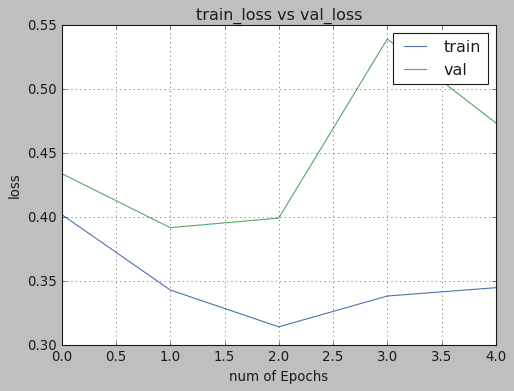

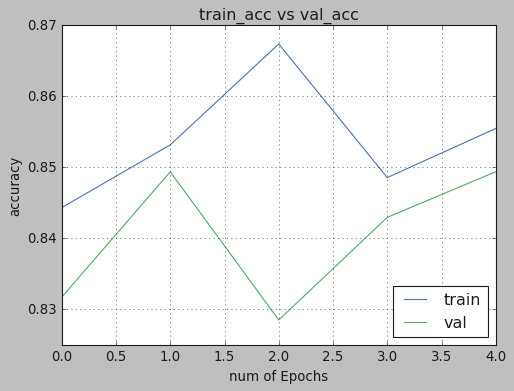

In [49]:
print(histogram(hist_augm_Inception))

In [29]:
model_Inception.save('model_InceptionAUGM.h5')

D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# VGG16

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 1)                

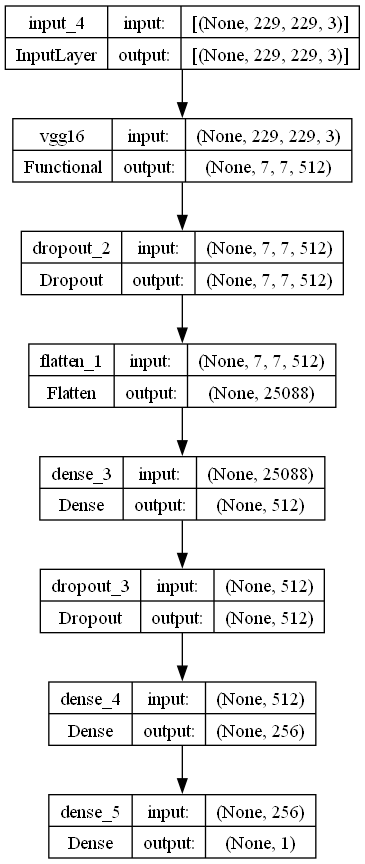

In [30]:

def VGG16_model():
    base_model = VGG16
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(Input(shape=(img_width_229, img_height_229,3)))
    model.add(base_model)
    
    model.add(Dropout(0.3))
    model.add(Flatten())
    #model.add(Dense(512, activation='leaky_relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

model_VGG = VGG16_model()
model_VGG.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model_VGG.summary()  
keras.utils.plot_model(model_VGG, show_shapes=True)

In [31]:
hist_VGG = model_VGG.fit(x_train229, y_train229, epochs= 20, validation_data= (x_test229, y_test229),callbacks=[early_stopping])


Epoch 1/20
163/163 [==============================] - 1005s 6s/step - loss: 2.2541 - accuracy: 0.9296 - precision: 0.9539 - recall: 0.9512 - val_loss: 3.9006 - val_accuracy: 0.8317 - val_precision: 0.7914 - val_recall: 0.9923
Epoch 2/20
163/163 [==============================] - 1003s 6s/step - loss: 0.4882 - accuracy: 0.9611 - precision: 0.9749 - recall: 0.9726 - val_loss: 6.4022 - val_accuracy: 0.7804 - val_precision: 0.7400 - val_recall: 1.0000
Epoch 3/20
163/163 [==============================] - 1003s 6s/step - loss: 0.2474 - accuracy: 0.9758 - precision: 0.9842 - recall: 0.9832 - val_loss: 3.3842 - val_accuracy: 0.8125 - val_precision: 0.7692 - val_recall: 1.0000
Epoch 4/20
163/163 [==============================] - 1004s 6s/step - loss: 0.1093 - accuracy: 0.9852 - precision: 0.9899 - recall: 0.9902 - val_loss: 2.9573 - val_accuracy: 0.7821 - val_precision: 0.7414 - val_recall: 1.0000
Epoch 5/20
163/163 [==============================] - 1004s 6s/step - loss: 0.0955 - accuracy: 0

1/1 [==============================] - 3s 3s/step


<Axes: >

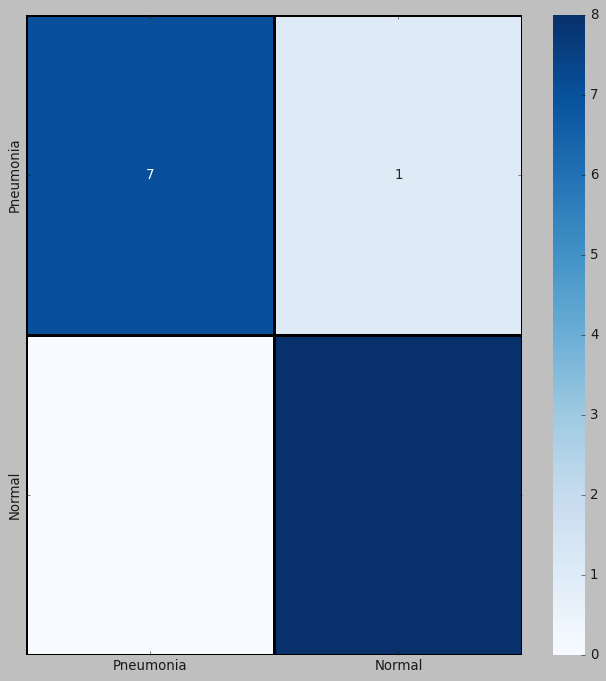

In [32]:
predict_VGG=model_VGG.predict(x_val229)
classesVGG=(predict_VGG>0.5).astype(int)

cm_VGG  = confusion_matrix(y_val229, classesVGG)
cm = pd.DataFrame(cm_VGG , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [33]:
roc_vgg16=roc_auc_score(y_val229,classesVGG)

In [34]:

f1_vgg16=f1_score(y_val229,classesVGG,average="binary")
f1_vgg16

0.9411764705882353

In [35]:
print(classification_report(y_val229, classesVGG, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.88      0.93         8
   Normal (Class 1)       0.89      1.00      0.94         8

           accuracy                           0.94        16
          macro avg       0.94      0.94      0.94        16
       weighted avg       0.94      0.94      0.94        16



(<Figure size 560x400 with 1 Axes>, <Figure size 560x400 with 1 Axes>)


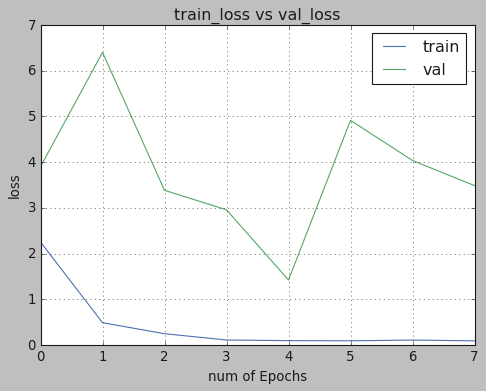

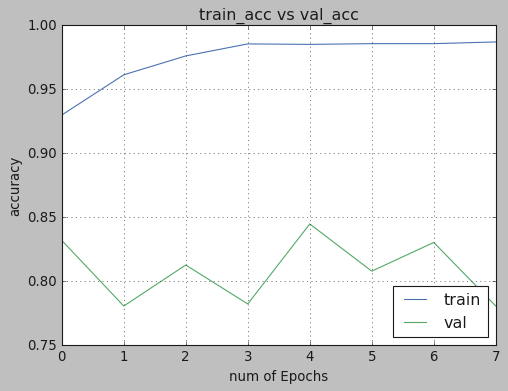

In [36]:
print(histogram(hist_VGG))

In [37]:
model_VGG.save('model_VGG.h5')

D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**VGG with augmentation**

In [38]:
hist_augm_VGG = model_VGG.fit(data_generator.flow(x_train229,y_train229,batch_size=batchsize, 
                                       seed=27,
                                       shuffle=False), 
    epochs= 20, validation_data= (x_test229, y_test229),callbacks=[early_stopping])


Epoch 1/20
163/163 [==============================] - 1020s 6s/step - loss: 0.4263 - accuracy: 0.9126 - precision: 0.9407 - recall: 0.9417 - val_loss: 0.5584 - val_accuracy: 0.8974 - val_precision: 0.8705 - val_recall: 0.9821
Epoch 2/20
163/163 [==============================] - 1020s 6s/step - loss: 0.2227 - accuracy: 0.9229 - precision: 0.9454 - recall: 0.9512 - val_loss: 0.3206 - val_accuracy: 0.8974 - val_precision: 0.8918 - val_recall: 0.9513
Epoch 3/20
163/163 [==============================] - 1020s 6s/step - loss: 0.1822 - accuracy: 0.9392 - precision: 0.9550 - recall: 0.9636 - val_loss: 0.3708 - val_accuracy: 0.8974 - val_precision: 0.8671 - val_recall: 0.9872
Epoch 4/20
163/163 [==============================] - 1020s 6s/step - loss: 0.1536 - accuracy: 0.9459 - precision: 0.9570 - recall: 0.9708 - val_loss: 0.2064 - val_accuracy: 0.9311 - val_precision: 0.9415 - val_recall: 0.9487
Epoch 5/20
163/163 [==============================] - 1020s 6s/step - loss: 0.1423 - accuracy: 0

1/1 [==============================] - 3s 3s/step


<Axes: >

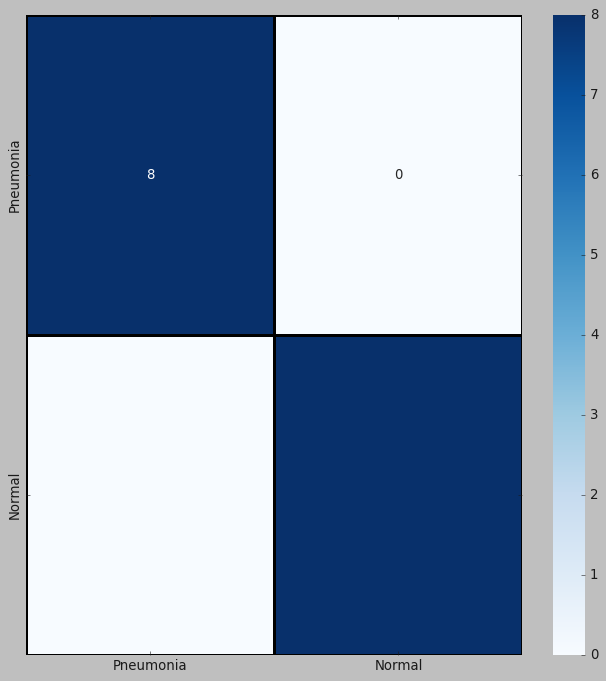

In [39]:
predict_aug_VGG=model_VGG.predict(x_val229)
classesVGG_augm=(predict_aug_VGG>0.5).astype(int)

cm_augm_VGG  = confusion_matrix(y_val229, classesVGG_augm)
cm = pd.DataFrame(cm_augm_VGG , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [40]:
roc_vgg16_augm=roc_auc_score(y_val229,classesVGG_augm)
roc_vgg16_augm

1.0

In [41]:

f1_vgg16_augm=f1_score(y_val229,classesVGG_augm,average="binary")
f1_vgg16_augm

1.0

In [42]:
print(classification_report(y_val229, classesVGG_augm, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      1.00      1.00         8
   Normal (Class 1)       1.00      1.00      1.00         8

           accuracy                           1.00        16
          macro avg       1.00      1.00      1.00        16
       weighted avg       1.00      1.00      1.00        16



(<Figure size 560x400 with 1 Axes>, <Figure size 560x400 with 1 Axes>)


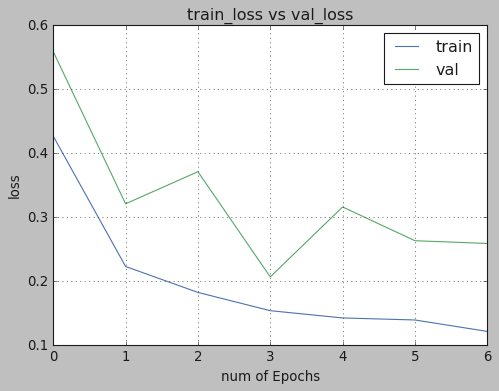

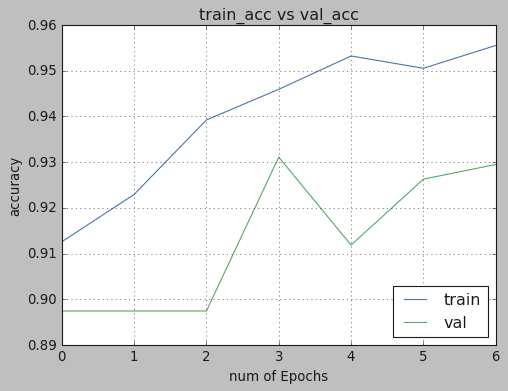

In [43]:
print(histogram(hist_augm_VGG))

In [44]:
model_VGG.save('model_VGGAUGM.h5')

D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# MobileNetV2



In [22]:
MobileNetV2=tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top = False, input_shape=(img_width_224, img_height_224, 3))


9406464/9406464 [==============================] - 1s 0us/step



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               

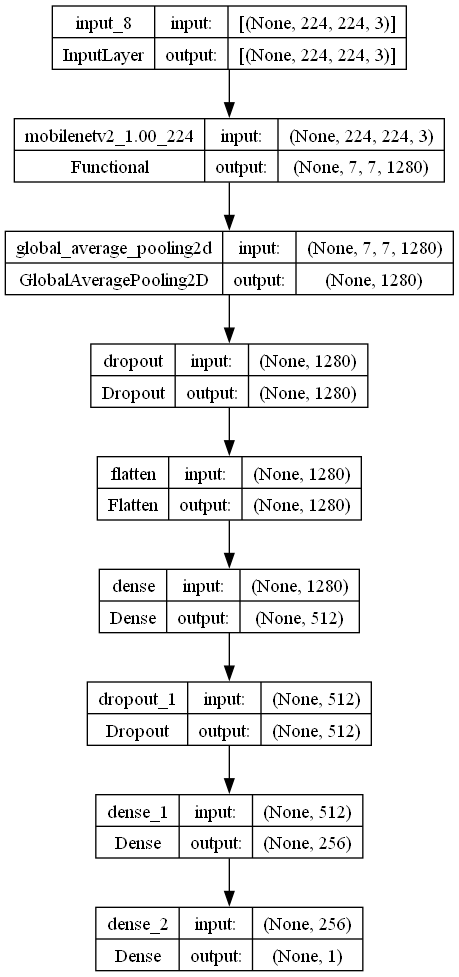

In [23]:

def MobileNetV2_model():
    base_model = MobileNetV2
    for layer in base_model.layers:
        layer.trainable = False


    model = Sequential()
    model.add(Input(shape=(img_width_224, img_height_224,3)))
    model.add(base_model)
    
    
    
    #model.add(Dense(512, activation='relu'))
    #model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    #model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

model_MobileNetV2 = MobileNetV2_model()
model_MobileNetV2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
model_MobileNetV2.summary()  
keras.utils.plot_model(model_MobileNetV2, show_shapes=True)

In [24]:
hist_mob = model_MobileNetV2.fit(x_train224,y_train224, 
    epochs= 20, validation_data= (x_test224, y_test224))

Epoch 1/20


163/163 [==============================] - 41s 220ms/step - loss: 0.2548 - accuracy: 0.8892 - precision: 0.9206 - recall: 0.9311 - val_loss: 0.6398 - val_accuracy: 0.7596 - val_precision: 0.7264 - val_recall: 0.9872
Epoch 2/20
163/163 [==============================] - 29s 180ms/step - loss: 0.1901 - accuracy: 0.9243 - precision: 0.9496 - recall: 0.9484 - val_loss: 0.4693 - val_accuracy: 0.8029 - val_precision: 0.7811 - val_recall: 0.9513
Epoch 3/20
163/163 [==============================] - 32s 197ms/step - loss: 0.1741 - accuracy: 0.9275 - precision: 0.9505 - recall: 0.9520 - val_loss: 0.6345 - val_accuracy: 0.7869 - val_precision: 0.7575 - val_recall: 0.9692
Epoch 4/20
163/163 [==============================] - 33s 203ms/step - loss: 0.1526 - accuracy: 0.9402 - precision: 0.9605 - recall: 0.9590 - val_loss: 0.6098 - val_accuracy: 0.7708 - val_precision: 0.7343 - val_recall: 0.9923
Epoch 5/20
163/163 [==============================] - 30s 183ms/step - loss: 0.1610 - accu

1/1 [==============================] - 0s 130ms/step


<Axes: >

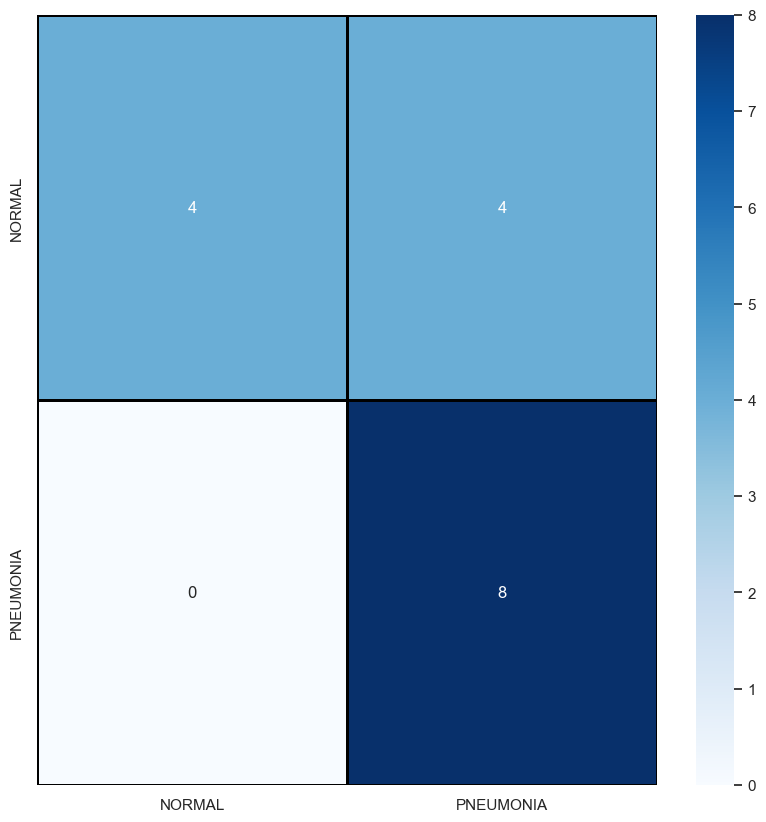

In [27]:
predict_mobv2=model_MobileNetV2.predict(x_val224)
classesmobv2=(predict_mobv2>0.5).astype(int)

cm_mob  = confusion_matrix(y_val224, classesmobv2)
cm = pd.DataFrame(cm_mob , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
labels=["NORMAL","PNEUMONIA"]
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [28]:
roc_mobil=roc_auc_score(y_val224,classesmobv2)
roc_mobil

0.75

In [29]:
f1_mobil=f1_score(y_val224,classesmobv2,average="binary")
f1_mobil

0.8

In [30]:
print(classification_report(y_val224, classesmobv2, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.50      0.67         8
   Normal (Class 1)       0.67      1.00      0.80         8

           accuracy                           0.75        16
          macro avg       0.83      0.75      0.73        16
       weighted avg       0.83      0.75      0.73        16



(<Figure size 700x500 with 1 Axes>, <Figure size 560x400 with 1 Axes>)


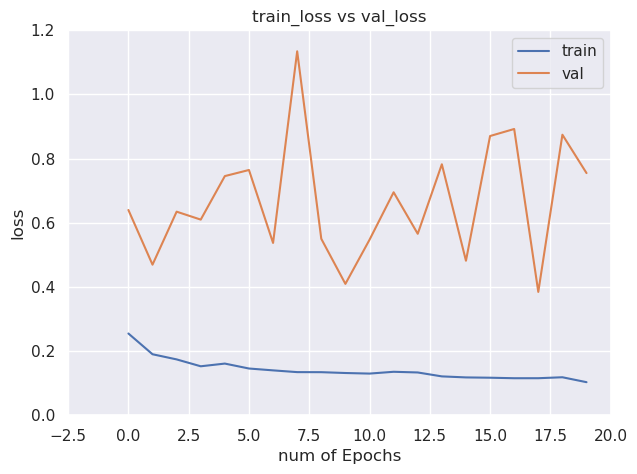

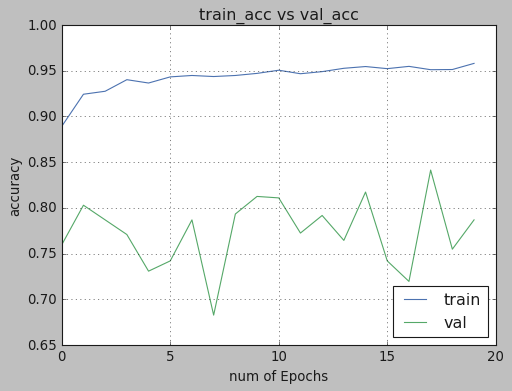

In [31]:
print(histogram(hist_mob))

In [32]:
model_MobileNetV2.save('MobilNetV2.h5')

D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**MobileNet with augmentation**

1/1 [==============================] - 0s 140ms/step


<Axes: >

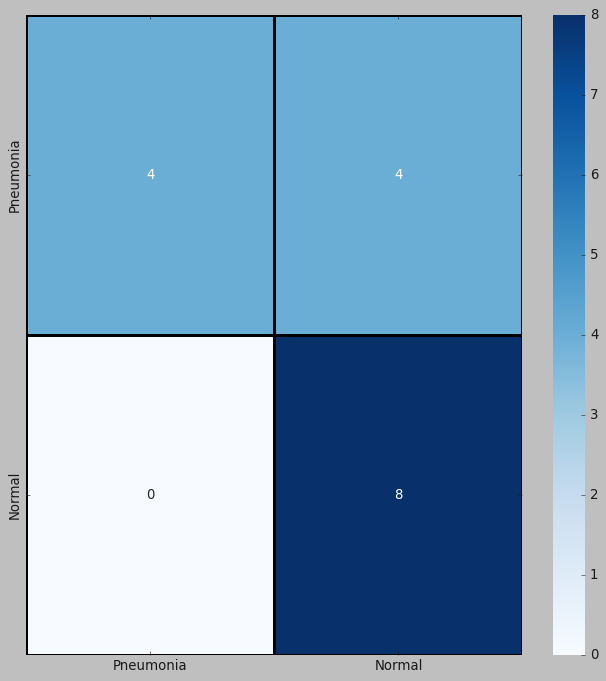

In [33]:
predict_mobv2_augm=model_MobileNetV2.predict(x_val224)
classesmobv2_augm=(predict_mobv2_augm>0.5).astype(int)
labels=["Pneumonia","Normal"]
cm_augm_mob  = confusion_matrix(y_val224, classesmobv2_augm)
cm = pd.DataFrame(cm_augm_mob , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [55]:
hist_augm_mob = model_MobileNetV2.fit(data_generator.flow(x_train224,y_train224,batch_size=batchsize, 
                                       seed=27,
                                       shuffle=False), 
    epochs= 20, validation_data= (x_test224, y_test224),callbacks=[early_stopping])

Epoch 1/20
163/163 [==============================] - 98s 585ms/step - loss: 0.2457 - accuracy: 0.9001 - precision: 0.9333 - recall: 0.9321 - val_loss: 0.3133 - val_accuracy: 0.8782 - val_precision: 0.8811 - val_recall: 0.9308
Epoch 2/20
163/163 [==============================] - 95s 584ms/step - loss: 0.2124 - accuracy: 0.9097 - precision: 0.9418 - recall: 0.9363 - val_loss: 0.3218 - val_accuracy: 0.8590 - val_precision: 0.8416 - val_recall: 0.9538
Epoch 3/20
163/163 [==============================] - 95s 582ms/step - loss: 0.2085 - accuracy: 0.9147 - precision: 0.9455 - recall: 0.9394 - val_loss: 0.3293 - val_accuracy: 0.8814 - val_precision: 0.9158 - val_recall: 0.8923
Epoch 4/20
163/163 [==============================] - 95s 582ms/step - loss: 0.1997 - accuracy: 0.9229 - precision: 0.9516 - recall: 0.9443 - val_loss: 0.3887 - val_accuracy: 0.8221 - val_precision: 0.7974 - val_recall: 0.9590


1/1 [==============================] - 0s 155ms/step


<Axes: >

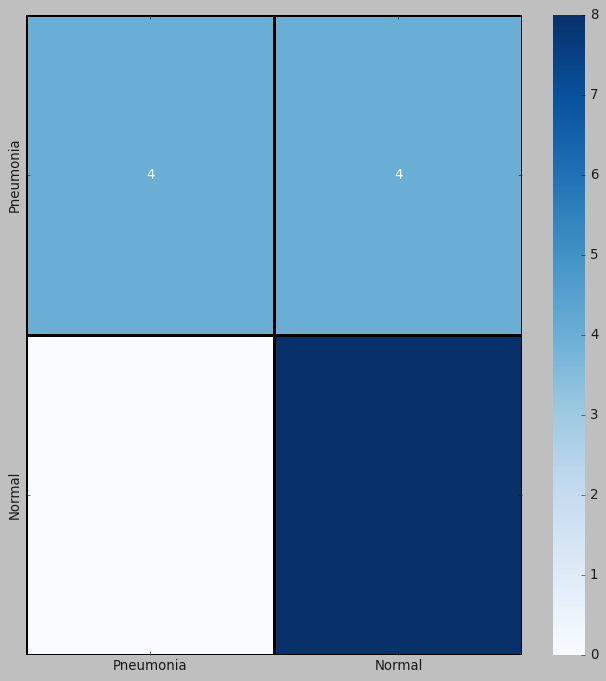

In [56]:
predict_mobv2_augm=model_MobileNetV2.predict(x_val224)
classesmobv2_augm=(predict_mobv2_augm>0.5).astype(int)
labels=["Pneumonia","Normal"]
cm_augm_mob  = confusion_matrix(y_val224, classesmobv2_augm)
cm = pd.DataFrame(cm_augm_mob , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [57]:
print(classification_report(y_val224, classesmobv2_augm, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.50      0.67         8
   Normal (Class 1)       0.67      1.00      0.80         8

           accuracy                           0.75        16
          macro avg       0.83      0.75      0.73        16
       weighted avg       0.83      0.75      0.73        16



In [58]:

roc_mobil_augm=roc_auc_score(y_val224,classesmobv2_augm)

In [59]:
f1_mobil_augm=f1_score(y_val224,classesmobv2_augm,average="binary")
f1_mobil_augm

0.8

(<Figure size 560x400 with 1 Axes>, <Figure size 560x400 with 1 Axes>)


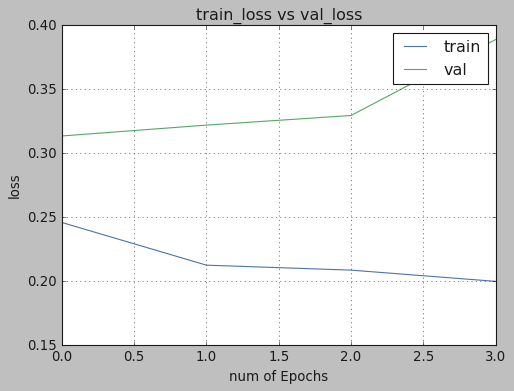

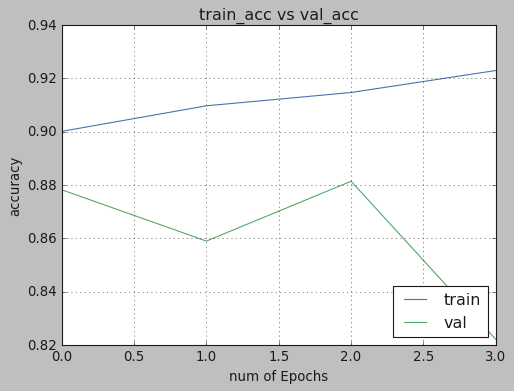

In [60]:
print(histogram(hist_augm_mob))

In [61]:

model_MobileNetV2.save('MobilNetV2AUGM.h5')


D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Conclusion


In [62]:
model=["Inception","Inception with augmentation","VGG16","VGG16 with augmentation","MobilNet","MobilNet with augmentation"]
roc=[roc_inc,roc_inc_aug,roc_vgg16,roc_vgg16_augm,roc_mobil,roc_mobil_augm]
f1=[f1_inc,f1_inc_augm,f1_vgg16,f1_vgg16_augm,f1_mobil,f1_mobil_augm]
result=pd.DataFrame(columns=["model","f1_score","roc_auc"])
result["model"]=model
result["roc_auc"]=roc
result["f1_score"]=f1

result

,model,f1_score,roc_auc
0,Inception,0.761905,0.6875
1,Inception with augmentation,0.800000,0.7500
2,VGG16,0.941176,0.9375
3,VGG16 with augmentation,1.000000,1.0000
4,MobilNet,0.800000,0.7500
5,MobilNet with augmentation,0.800000,0.7500


# References
[Efficient Pneumonia Detection in Chest Xray Images Using Deep Transfer Learning](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7345724/)

# 
# 